In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data

In [2]:
import yfinance as yf
yf.pdr_override()

In [3]:
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME='goog_data.pkl'

In [4]:
def load_goog_data() -> pd.DataFrame:
    try:
        goog_data = pd.read_pickle(SRC_DATA_FILENAME)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        goog_data = data.get_data_yahoo('GOOG', start=start_date, end=end_date)
        goog_data.to_pickle(SRC_DATA_FILENAME)
    return goog_data

### Support and resistance

In [5]:
goog_data2 = load_goog_data()
goog_data = goog_data2.tail(620)

File data found...reading GOOG data


In [6]:
lows=goog_data['Low']
highs=goog_data['High']

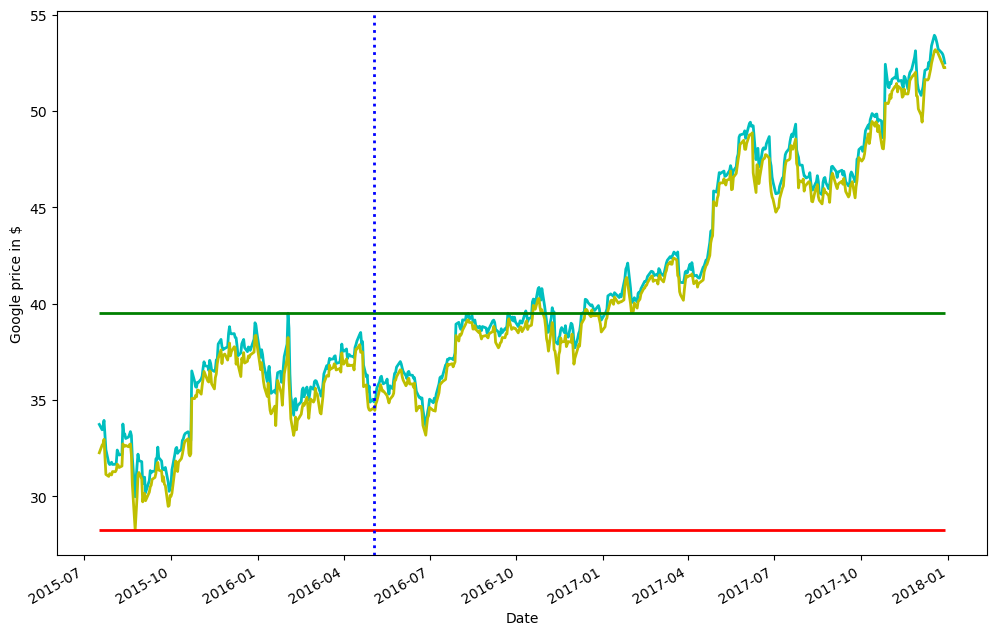

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
highs.plot(ax=ax1, color='c', lw=2.)
lows.plot(ax=ax1, color='y', lw=2.)
plt.hlines(highs.head(200).max(),lows.index.values[0],lows.index.values[-1],linewidth=2, color='g')
plt.hlines(lows.head(200).min(),lows.index.values[0],lows.index.values[-1],linewidth=2, color='r')
plt.axvline(linewidth=2,color='b',x=lows.index.values[200],linestyle=':')
plt.show()

In [8]:
goog_data_signal = pd.DataFrame(index=goog_data2.index)
goog_data_signal['price'] = goog_data2['Adj Close']

In [9]:
def trading_support_resistance(data, bin_width=20):
    data['sup_tolerance'] = pd.Series(np.zeros(len(data)))
    data['res_tolerance'] = pd.Series(np.zeros(len(data)))
    data['sup_count'] = pd.Series(np.zeros(len(data)))
    data['res_count'] = pd.Series(np.zeros(len(data)))
    data['sup'] = pd.Series(np.zeros(len(data)))
    data['res'] = pd.Series(np.zeros(len(data)))
    data['positions'] = pd.Series(np.zeros(len(data)))
    data['signal'] = pd.Series(np.zeros(len(data)))
    in_support=0
    in_resistance=0
    for x in range((bin_width - 1) + bin_width, len(data)):
        data_section = data[x - bin_width:x + 1]
        support_level=min(data_section['price'])
        resistance_level=max(data_section['price'])
        range_level=resistance_level-support_level
        data['res'][x]=resistance_level
        data['sup'][x]=support_level
        data['sup_tolerance'][x]=support_level + 0.2 * range_level
        data['res_tolerance'][x]=resistance_level - 0.2 * range_level
        if data['price'][x]>=data['res_tolerance'][x] and data['price'][x] <= data['res'][x]:
            in_resistance+=1
            data['res_count'][x]=in_resistance
        elif data['price'][x] <= data['sup_tolerance'][x] and data['price'][x] >= data['sup'][x]:
            in_support += 1
            data['sup_count'][x] = in_support
        else:
            in_support=0
            in_resistance=0
        if in_resistance>2:
            data['signal'][x]=1
        elif in_support>2:
            data['signal'][x]=0
        else:
            data['signal'][x] = data['signal'][x-1]
    
    data['positions']=data['signal'].diff()

trading_support_resistance(goog_data_signal)

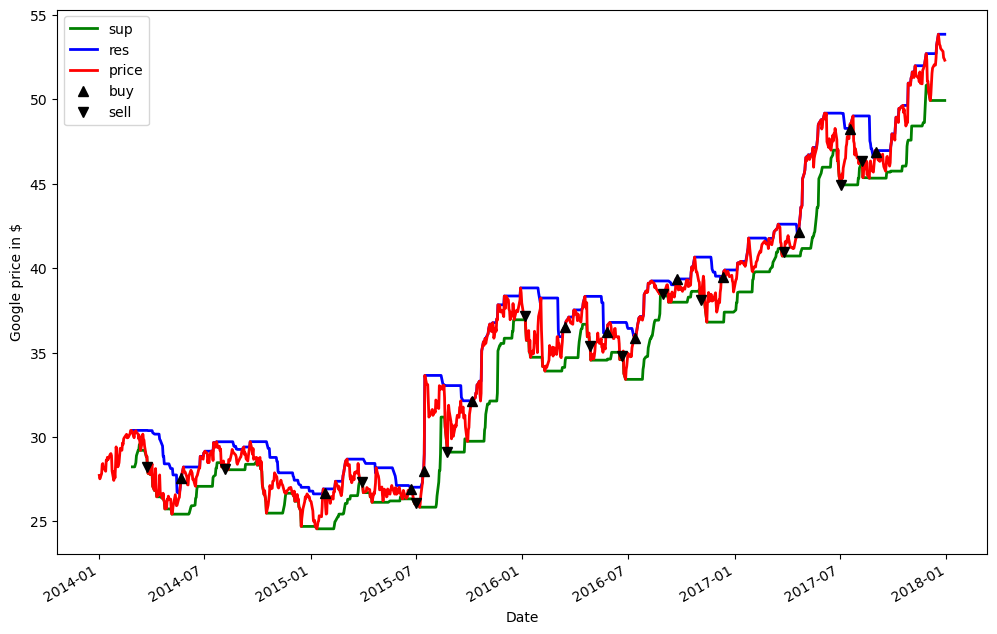

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data_signal['sup'].plot(ax=ax1, color='g', lw=2.)
goog_data_signal['res'].plot(ax=ax1, color='b', lw=2.)
goog_data_signal['price'].plot(ax=ax1, color='r', lw=2.)
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == 1.0].index,
         goog_data_signal.price[goog_data_signal.positions == 1.0],
         '^', markersize=7, color='k',label='buy')
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == -1.0].index,
         goog_data_signal.price[goog_data_signal.positions == -1.0],
         'v', markersize=7, color='k',label='sell')
plt.legend()
plt.show()


## Creating trading signals based on fundamental technical analysis
* Simple Moving Average (SMA)
* Exponential Moving Average (EMA)
* Absolute Price Oscillator (APO)
* Moving Average Convergence Divergence (MACD)
* Bollinger Bands (BBANDS)
* Relative Strength Indicator (RSI)
* Standard Deviation (STDEV)
* Momentum (MOM)

### Simple moving average

The Simple Moving Average (SMA) is calculated\
 by adding the price of an instrument over a number of time periods\
 and then dividing the sum by the number of time periods. The SMA\
 is basically the average price of the given time period, with equal\
 weighting given to the price of each period.

$$
SimpleMovingAverage=\frac{\sum_{i=1}^NP_i}{N}
$$
Where:\
$P_i$: Price at time period $i$\
$N$: Number of prices added together or the number of time periods

In [11]:
goog_data2 = load_goog_data()
goog_data = goog_data2.tail(620)
close = goog_data['Close']

File data found...reading GOOG data


In [12]:
import statistics as stats

time_period = 20 # number of days over which to average
history = [] # to track a history of prices
sma_values = [] # to track simple moving average values
for close_price in close:
    history.append(close_price)
    if len(history) > time_period: # we remove oldest price because we only average over last 'time_period' prices
        del (history[0])

    sma_values.append(stats.mean(history))

In [13]:
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(Simple20DayMovingAverage=pd.Series(sma_values, index=goog_data.index))

In [14]:
close_price = goog_data['ClosePrice']
sma = goog_data['Simple20DayMovingAverage']

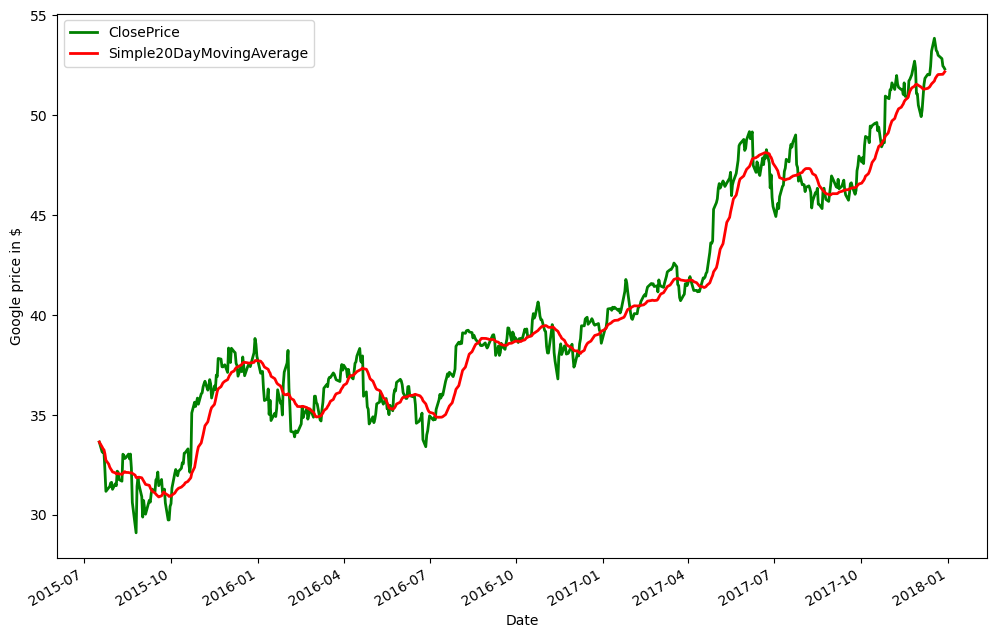

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
sma.plot(ax=ax1, color='r', lw=2., legend=True)
plt.show()

### Exponential moving average

The Exponential Moving Average (EMA) represents an average of prices, but places more weight on recent prices. The weighting applied to the most recent price depends on the selected period of the moving average. The shorter the period for the EMA, the more weight that will be applied to the most recent price.

EMA = ( P - EMAp ) * K + EMAp

Where:\
P = Price for the current period\
EMAp = the Exponential moving Average for the previous period\
K = the smoothing constant, equal to 2 / (n + 1)\
n = the number of periods in a simple moving average roughly approximated by the EMA

In [16]:
goog_data2 = load_goog_data()
goog_data = goog_data2.tail(620)
close = goog_data['Close']

File data found...reading GOOG data


In [17]:
import statistics as stats

num_periods = 20 # number of days over which to average
K = 2 / (num_periods + 1) # smoothing constant
ema_p = 0

ema_values = [] # to hold computed EMA values
for close_price in close:
    if (ema_p == 0): # first observation, EMA = current-price
        ema_p = close_price
    else:
        ema_p = (close_price - ema_p) * K + ema_p

    ema_values.append(ema_p)

In [18]:
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(Exponential20DayMovingAverage=pd.Series(ema_values, index=goog_data.index))

In [19]:
close_price = goog_data['ClosePrice']
ema = goog_data['Exponential20DayMovingAverage']

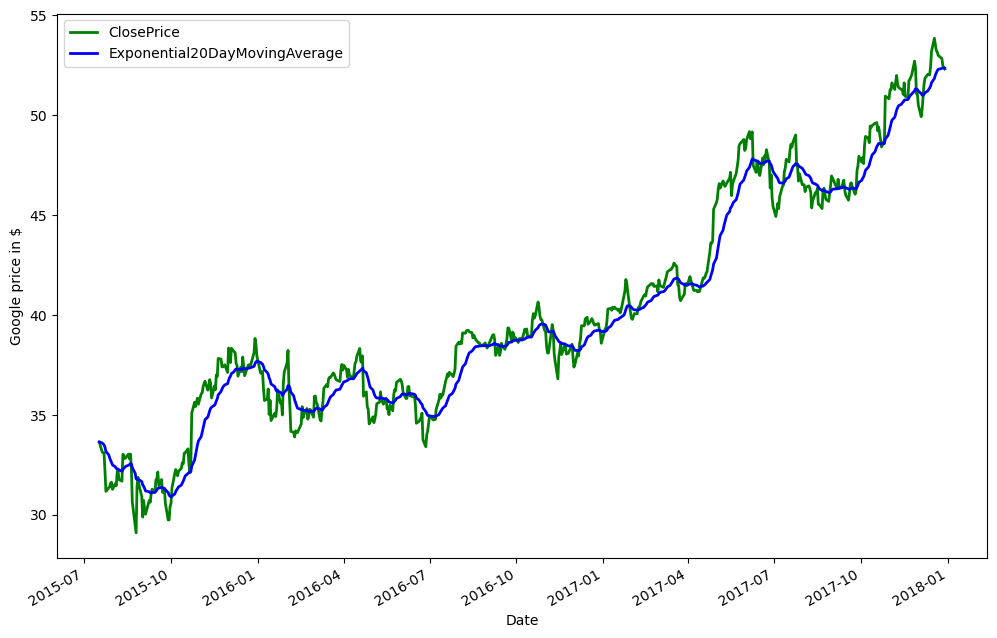

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema.plot(ax=ax1, color='b', lw=2., legend=True)
plt.show()

### Absolute price oscillator

The Absolute Price Oscillator (APO) is based on the absolute differences between two moving averages of different lengths, a ‘Fast’ and a ‘Slow’ moving average.

APO = Fast Exponential Moving Average - Slow Exponential Moving Average

In [21]:
goog_data2 = load_goog_data()
goog_data = goog_data2.tail(620)
close = goog_data['Close']

File data found...reading GOOG data


In [22]:
num_periods_fast = 10 # time period for the fast EMA
K_fast = 2 / (num_periods_fast + 1) # smoothing factor for fast EMA
ema_fast = 0
num_periods_slow = 40 # time period for slow EMA
K_slow = 2 / (num_periods_slow + 1) # smoothing factor for slow EMA
ema_slow = 0

In [23]:
ema_fast_values = [] # we will hold fast EMA values for visualization purposes
ema_slow_values = [] # we will hold slow EMA values for visualization purposes
apo_values = [] # track computed absolute price oscillator values
for close_price in close:
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_fast + ema_fast
        ema_slow = (close_price - ema_slow) * K_slow + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)
    apo_values.append(ema_fast - ema_slow)

In [24]:
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=goog_data.index))
goog_data = goog_data.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=goog_data.index))
goog_data = goog_data.assign(AbsolutePriceOscillator=pd.Series(apo_values, index=goog_data.index))

In [25]:
close_price = goog_data['ClosePrice']
ema_f = goog_data['FastExponential10DayMovingAverage']
ema_s = goog_data['SlowExponential40DayMovingAverage']
apo = goog_data['AbsolutePriceOscillator']

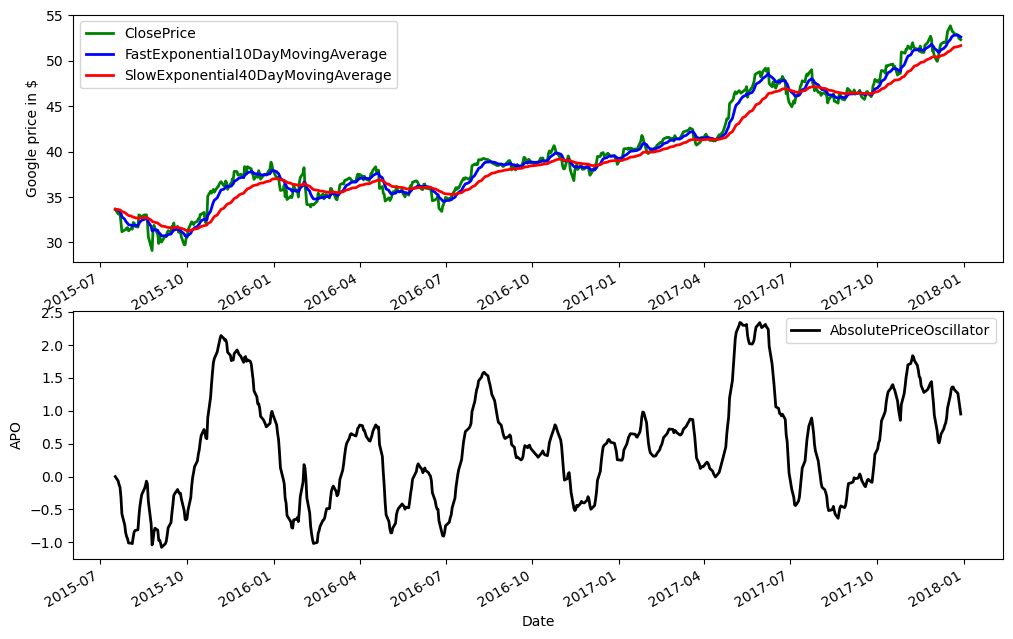

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema_f.plot(ax=ax1, color='b', lw=2., legend=True)
ema_s.plot(ax=ax1, color='r', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='APO')
apo.plot(ax=ax2, color='black', lw=2., legend=True)
plt.show()

### Moving average convergence divergence

The Moving Average Convergence Divergence (MACD) was developed by Gerald Appel, and is based on the differences between two moving averages of different lengths, a Fast and a Slow moving average. A second line, called the Signal line is plotted as a moving average of the MACD. A third line, called the MACD Histogram is optionally plotted as a histogram of the difference between the MACD and the Signal Line.

MACD = FastMA - SlowMA

Where:\
FastMA is the shorter moving average and SlowMA is the longer moving average.\
SignalLine = MovAvg (MACD)\
MACD Histogram = MACD - SignalLine

In [27]:
goog_data2 = load_goog_data()
goog_data = goog_data2.tail(620)
close = goog_data['Close']

File data found...reading GOOG data


In [28]:
num_periods_fast = 10 # fast EMA time period
K_fast = 2 / (num_periods_fast + 1) # fast EMA smoothing factor
ema_fast = 0
num_periods_slow = 40 # slow EMA time period
K_slow = 2 / (num_periods_slow + 1) # slow EMA smoothing factor
ema_slow = 0
num_periods_macd = 20 # MACD EMA time period
K_macd = 2 / (num_periods_macd + 1) # MACD EMA smoothing factor
ema_macd = 0

In [29]:
ema_fast_values = [] # track fast EMA values for visualization purposes
ema_slow_values = [] # track slow EMA values for visualization purposes
macd_values = [] # track MACD values for visualization purposes
macd_signal_values = [] # MACD EMA values tracker
macd_historgram_values = [] # MACD - MACD-EMA
for close_price in close:
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_fast + ema_fast
        ema_slow = (close_price - ema_slow) * K_slow + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    macd = ema_fast - ema_slow # MACD is fast_MA - slow_EMA
    if ema_macd == 0:
        ema_macd = macd
    else:
        ema_macd = (macd - ema_macd) * K_macd + ema_macd # signal is EMA of MACD values

    macd_values.append(macd)
    macd_signal_values.append(ema_macd)
    macd_historgram_values.append(macd - ema_macd)

In [30]:
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=goog_data.index))
goog_data = goog_data.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=goog_data.index))
goog_data = goog_data.assign(MovingAverageConvergenceDivergence=pd.Series(macd_values, index=goog_data.index))
goog_data = goog_data.assign(Exponential20DayMovingAverageOfMACD=pd.Series(macd_signal_values, index=goog_data.index))
goog_data = goog_data.assign(MACDHistorgram=pd.Series(macd_historgram_values, index=goog_data.index))

In [31]:
close_price = goog_data['ClosePrice']
ema_f = goog_data['FastExponential10DayMovingAverage']
ema_s = goog_data['SlowExponential40DayMovingAverage']
macd = goog_data['MovingAverageConvergenceDivergence']
ema_macd = goog_data['Exponential20DayMovingAverageOfMACD']
macd_histogram = goog_data['MACDHistorgram']

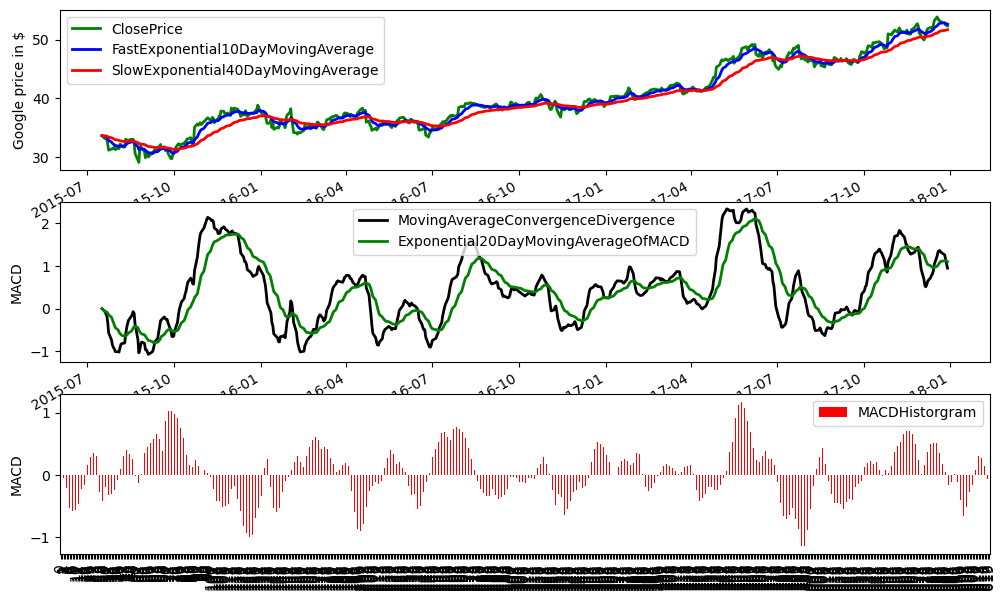

In [32]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(311, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema_f.plot(ax=ax1, color='b', lw=2., legend=True)
ema_s.plot(ax=ax1, color='r', lw=2., legend=True)
ax2 = fig.add_subplot(312, ylabel='MACD')
macd.plot(ax=ax2, color='black', lw=2., legend=True)
ema_macd.plot(ax=ax2, color='g', lw=2., legend=True)
ax3 = fig.add_subplot(313, ylabel='MACD')
macd_histogram.plot(ax=ax3, color='r', kind='bar', legend=True, use_index=False)
plt.show()

### Bollinger bands

The Bollinger Band (BBANDS) study created by John Bollinger plots upper and lower envelope bands around the price of the instrument. The width of the bands is based on the standard deviation of the closing prices from a moving average of price.

Middle Band = n-period moving average

Upper Band = Middle Band + (y * n-period standard deviation)

Lower Band = Middle Band - (y * n-period standard deviation)

Where:\
n = number of periods\
y = factor to apply to the standard deviation value, (typical default for y = 2)

Detailed:\
Calculate the moving average.\
 The formula is:\
d = ((P1-MA)^2 + (P2-MA)^2 + ... (Pn-MA)^2)/n

Pn is the price you pay for the nth interval n is the number of periods you select Subtract the moving average from each of the individual data points used in the moving average calculation. This gives you a list of deviations from the average. Square each deviation and add them all together. Divide this sum by the number of periods you selected.

Take the square root of d. This gives you the standard deviation.

delta = sqrt(d)

Compute the bands by using the following formulas:\
Upper Band = MA + delta\
Middle Band = MA\
Lower Band = MA - delta

In [33]:
goog_data2 = load_goog_data()
goog_data = goog_data2.tail(620)
close = goog_data['Close']

File data found...reading GOOG data


In [34]:
import statistics as stats
import math as math

time_period = 20 # history length for Simple Moving Average for middle band
stdev_factor = 2 # Standard Deviation Scaling factor for the upper and lower bands
history = [] # price history for computing simple moving average
sma_values = [] # moving average of prices for visualization purposes
upper_band = [] # upper band values
lower_band = [] # lower band values

In [35]:
for close_price in close:
    history.append(close_price)
    if len(history) > time_period: # we only want to maintain at most 'time_period' number of price observations
        del (history[0])

    sma = stats.mean(history)
    sma_values.append(sma) # simple moving average or middle band
    variance = 0 # variance is the square of standard deviation
    for hist_price in history:
        variance = variance + ((hist_price - sma) ** 2)

    stdev = math.sqrt(variance / len(history)) # use square root to get standard deviation

    upper_band.append(sma + stdev_factor * stdev)
    lower_band.append(sma - stdev_factor * stdev)

In [36]:
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(MiddleBollingerBand20DaySMA=pd.Series(sma_values, index=goog_data.index))
goog_data = goog_data.assign(UpperBollingerBand20DaySMA2StdevFactor=pd.Series(upper_band, index=goog_data.index))
goog_data = goog_data.assign(LowerBollingerBand20DaySMA2StdevFactor=pd.Series(lower_band, index=goog_data.index))

In [37]:
close_price = goog_data['ClosePrice']
mband = goog_data['MiddleBollingerBand20DaySMA']
uband = goog_data['UpperBollingerBand20DaySMA2StdevFactor']
lband = goog_data['LowerBollingerBand20DaySMA2StdevFactor']

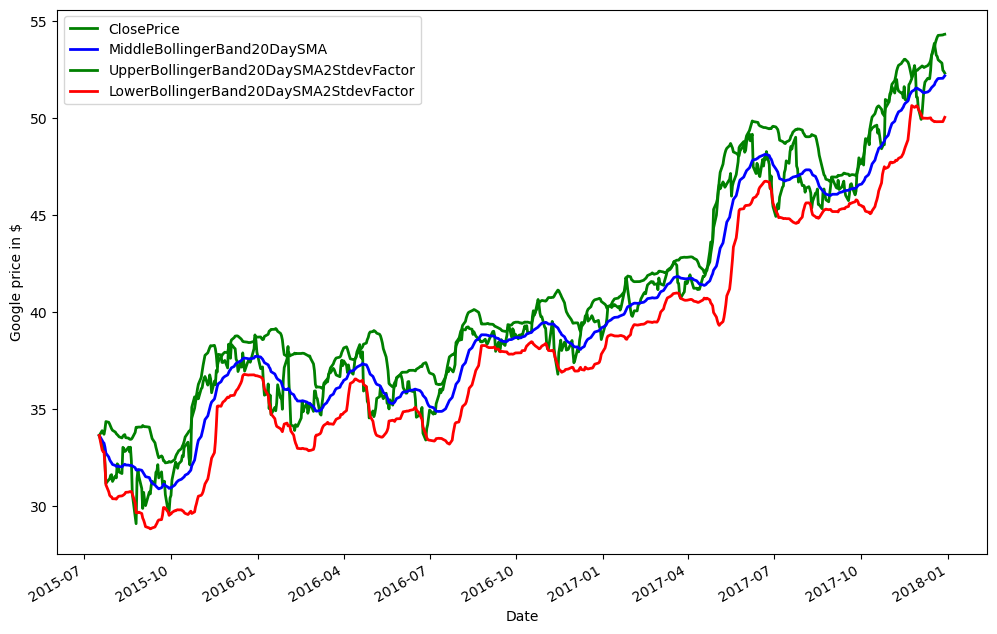

In [38]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
mband.plot(ax=ax1, color='b', lw=2., legend=True)
uband.plot(ax=ax1, color='g', lw=2., legend=True)
lband.plot(ax=ax1, color='r', lw=2., legend=True)
plt.show()

### Relative strength indicator

The Relative Strength Index (RSI) was published by J. Welles Wilder. The current price is normalized as a percentage between 0 and 100. The name of this oscillator is misleading because it does not compare the instrument relative to another instrument or set of instruments, but rather represents the current price relative to other recent pieces within the selected lookback window length.

RSI = 100 - (100 / (1 + RS))

Where:\
RS = ratio of smoothed average of n-period gains divided by the absolute value of the smoothed average of n-period losses.

In [39]:
goog_data2 = load_goog_data()
goog_data = goog_data2.tail(620)
close = goog_data['Close']

File data found...reading GOOG data


In [40]:
import statistics as stats

time_period = 20 # look back period to compute gains & losses
gain_history = [] # history of gains over look back period (0 if no gain, magnitude of gain if gain)
loss_history = [] # history of losses over look back period (0 if no loss, magnitude of loss if loss)
avg_gain_values = [] # track avg gains for visualization purposes
avg_loss_values = [] # track avg losses for visualization purposes
rsi_values = [] # track computed RSI values
last_price = 0 # current_price - last_price > 0 => gain. current_price - last_price < 0 => loss.

In [41]:
for close_price in close:
    if last_price == 0:
        last_price = close_price

    gain_history.append(max(0, close_price - last_price))
    loss_history.append(max(0, last_price - close_price))
    last_price = close_price

    if len(gain_history) > time_period: # maximum observations is equal to lookback period
        del (gain_history[0])
        del (loss_history[0])

    avg_gain = stats.mean(gain_history) # average gain over lookback period
    avg_loss = stats.mean(loss_history) # average loss over lookback period

    avg_gain_values.append(avg_gain)
    avg_loss_values.append(avg_loss)

    rs = 0
    if avg_loss > 0: # to avoid division by 0, which is undefined
        rs = avg_gain / avg_loss

    rsi = 100 - (100 / (1 + rs))
    rsi_values.append(rsi)

In [42]:
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthAvgGainOver20Days=pd.Series(avg_gain_values, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthAvgLossOver20Days=pd.Series(avg_loss_values, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthIndicatorOver20Days=pd.Series(rsi_values, index=goog_data.index))

In [43]:
close_price = goog_data['ClosePrice']
rs_gain = goog_data['RelativeStrengthAvgGainOver20Days']
rs_loss = goog_data['RelativeStrengthAvgLossOver20Days']
rsi = goog_data['RelativeStrengthIndicatorOver20Days']

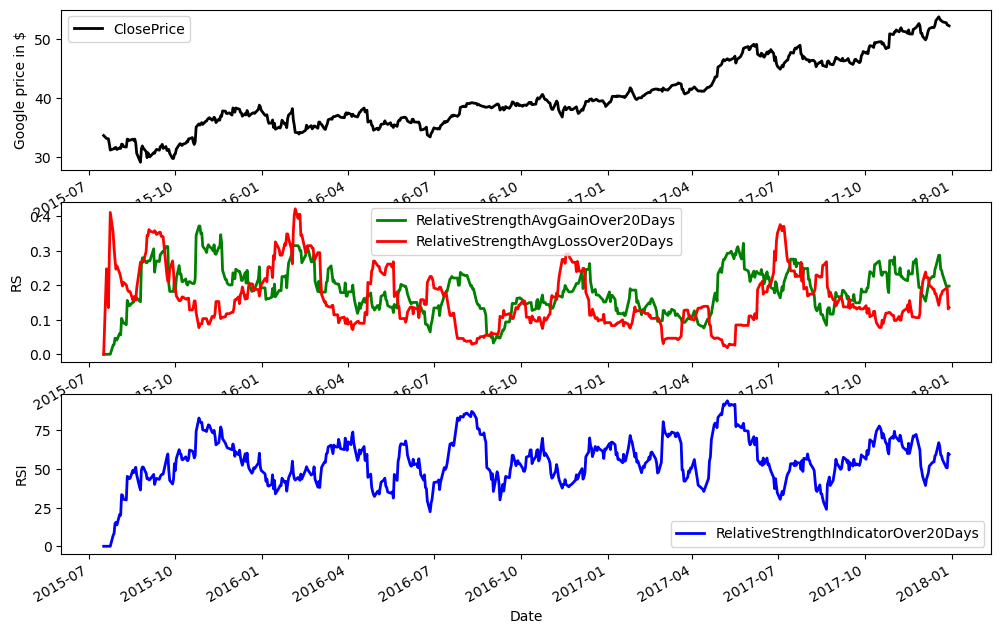

In [44]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(311, ylabel='Google price in $')
close_price.plot(ax=ax1, color='black', lw=2., legend=True)
ax2 = fig.add_subplot(312, ylabel='RS')
rs_gain.plot(ax=ax2, color='g', lw=2., legend=True)
rs_loss.plot(ax=ax2, color='r', lw=2., legend=True)
ax3 = fig.add_subplot(313, ylabel='RSI')
rsi.plot(ax=ax3, color='b', lw=2., legend=True)
plt.show()

### Standard deviation

Standard Deviation is a statistical calculation used to measure the variability. In trading this value is known as volatility. A low standard deviation indicates that the data points tend to be very close to the mean, whereas high standard deviation indicates that the data points are spread out over a large range of values.

n = number of periods

Calculate the moving average.\
The formula is:\
d = ((P1-MA)^2 + (P2-MA)^2 + ... (Pn-MA)^2)/n

Pn is the price you pay for the nth interval n is the number of periods you select

Take the square root of d. This gives you the standard deviation.

stddev = sqrt(d)

In [45]:
goog_data2 = load_goog_data()
goog_data = goog_data2.tail(620)
close = goog_data['Close']

File data found...reading GOOG data


In [46]:
import statistics as stats
import math as math

time_period = 20 # look back period
history = [] # history of prices
sma_values = [] # to track moving average values for visualization purposes
stddev_values = [] # history of computed stdev values

In [47]:
for close_price in close:
    history.append(close_price)
    if len(history) > time_period: # we track at most 'time_period' number of prices
        del (history[0])

    sma = stats.mean(history)
    sma_values.append(sma)
    variance = 0 # variance is square of standard deviation
    for hist_price in history:
        variance = variance + ((hist_price - sma) ** 2)

    stdev = math.sqrt(variance / len(history))

    stddev_values.append(stdev)

In [48]:
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(StandardDeviationOver20Days=pd.Series(stddev_values, index=goog_data.index))

In [49]:
close_price = goog_data['ClosePrice']
stddev = goog_data['StandardDeviationOver20Days']

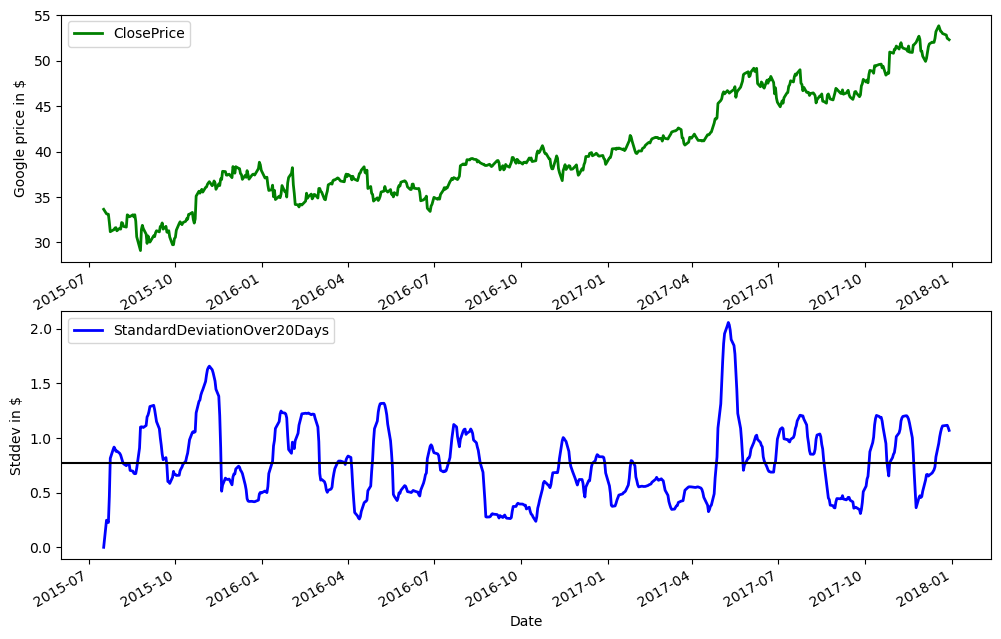

In [50]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='Stddev in $')
stddev.plot(ax=ax2, color='b', lw=2., legend=True)
ax2.axhline(y=stats.mean(stddev_values), color='k')
plt.show()

### Momentum

The Momentum (MOM) indicator compares the current price with the previous price from a selected number of periods ago. This indicator is similar to the “Rate of Change” indicator, but the MOM does not normalize the price, so different instruments can have different indicator values based on their point values.

MOM =  Price - Price of n periods ago

In [51]:
goog_data2 = load_goog_data()
goog_data = goog_data2.tail(620)
close = goog_data['Close']

File data found...reading GOOG data


In [52]:
time_period = 20 # how far to look back to find reference price to compute momentum
history = [] # history of observed prices to use in momentum calculation
mom_values = [] # track momentum values for visualization purposes

In [53]:
for close_price in close:
    history.append(close_price)
    if len(history) > time_period: # history is at most 'time_period' number of observations
        del (history[0])

    mom = close_price - history[0]
    mom_values.append(mom)

In [54]:
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(MomentumFromPrice20DaysAgo=pd.Series(mom_values, index=goog_data.index))

In [55]:
close_price = goog_data['ClosePrice']
mom = goog_data['MomentumFromPrice20DaysAgo']

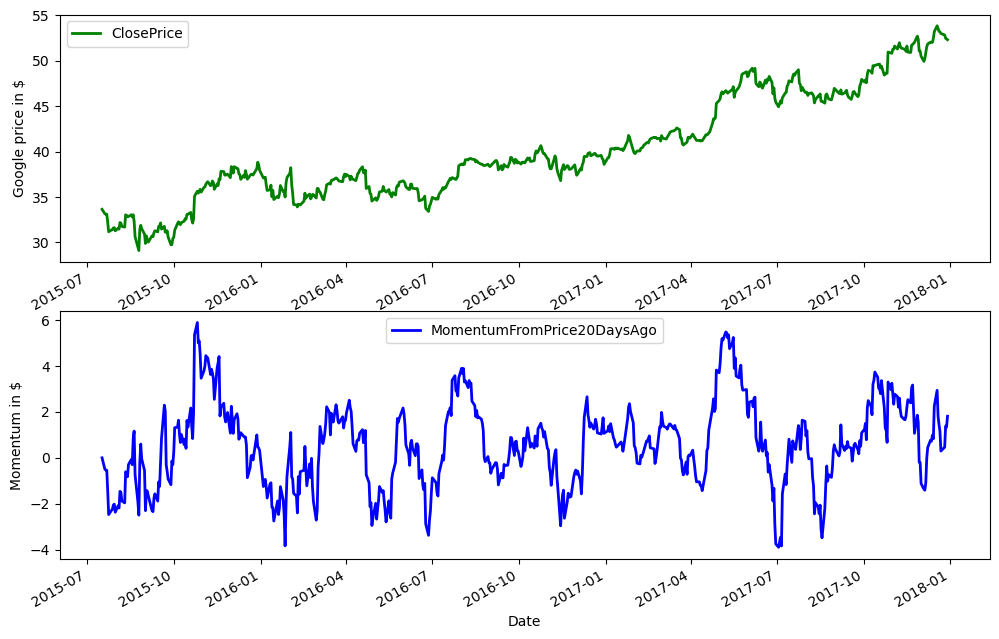

In [56]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='Momentum in $')
mom.plot(ax=ax2, color='b', lw=2., legend=True)
plt.show()

### Implementing advanced concepts, such as seasonality, in trading instruments

1. We will write the code to regroup the data by months, calculate and return the monthly returns, and then compare these returns in a histogram. We will observe that GOOG has a higher return in October:

In [57]:
start_date2 = '2001-01-01'
end_date2 = '2018-01-01'
SRC_DATA_FILENAME2='goog_data_large.pkl'

In [58]:
def load_goog_data_large() -> pd.DataFrame:
    try:
        goog_data = pd.read_pickle(SRC_DATA_FILENAME2)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        goog_data = data.get_data_yahoo('GOOG', start=start_date2, end=end_date2)
        goog_data.to_pickle(SRC_DATA_FILENAME2)
    return goog_data

In [59]:
goog_data = load_goog_data_large()
goog_data

File data found...reading GOOG data


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
...,...,...,...,...,...,...
2017-12-22,53.055500,53.209999,52.972000,53.006001,53.006001,15102000
2017-12-26,52.903500,53.006001,52.509998,52.837002,52.837002,15212000
2017-12-27,52.869499,52.918499,52.402500,52.468498,52.468498,25438000


In [60]:
goog_monthly_return = goog_data['Adj Close'].pct_change().groupby(
    [goog_data['Adj Close'].index.year,
     goog_data['Adj Close'].index.month]).mean()

In [61]:
goog_montly_return_list=[]
for i in range(len(goog_monthly_return)):
    goog_montly_return_list.append({
        'month':goog_monthly_return.index[i][1],
        'monthly_return': goog_monthly_return.iloc[i]})

In [62]:
goog_montly_return_list=pd.DataFrame(goog_montly_return_list,
                                     columns=('month','monthly_return'))

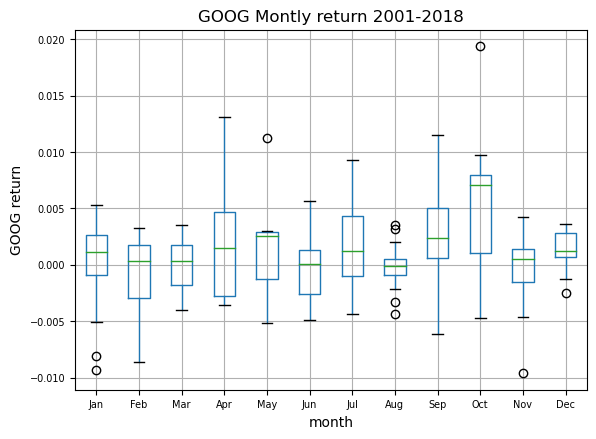

In [63]:
goog_montly_return_list.boxplot(column='monthly_return', by='month')
ax = plt.gca()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels=['Jan','Feb','Mar','Apr','May','Jun',\
        'Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(labels)
ax.set_ylabel('GOOG return')
plt.tick_params(axis='both', which='major', labelsize=7)
plt.title("GOOG Montly return 2001-2018")
plt.suptitle("")
plt.show()

In this screenshot, we observe that there are repetitive patterns. The month of October is the month when the return seems to be the highest, unlike November, where we observe a drop in the return.

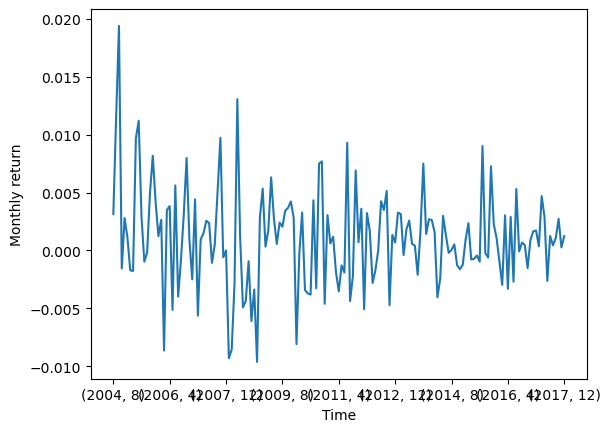

In [64]:
fig = plt.figure()
goog_data['Adj Close'].pct_change().groupby(
    [goog_data['Adj Close'].index.month])
ax1 = fig.add_subplot(111, ylabel='Monthly return')
goog_monthly_return.plot()
plt.xlabel('Time')
plt.show()

2. Since it is a time series, we will study the stationary (mean, variance remain constant over time). In the following code, we will check this property because the following time series models work on the assumption that time series are stationary:

* Constant mean
* Constant variance
* Time-independent autocovariance

In [65]:
# Displaying rolling statistics
def plot_rolling_statistics_ts(ts, titletext,ytext, window_size=12):
    ts.plot(color='red', label='Original', lw=0.5)
    ts.rolling(window_size).mean().plot(
            color='blue',label='Rolling Mean')
    ts.rolling(window_size).std().plot(
            color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.ylabel(ytext)
    plt.title(titletext)
    plt.show(block=False)

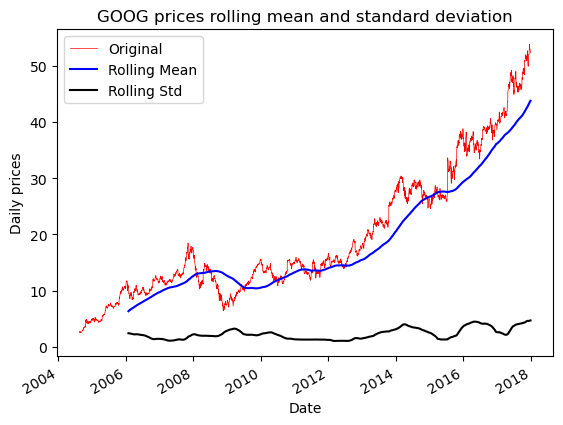

In [66]:
plot_rolling_statistics_ts(goog_data['Adj Close'],'GOOG prices rolling mean and standard deviation','Daily prices',365)

When observing the plot of the `GOOG` daily prices, the following can be stated:

* We can see that the price is growing over time; this is a trend.
* The wave effect we are observing on the `GOOG` daily prices comes from seasonality.
* When we make a time series stationary, we remove the trend and seasonality by modeling and removing them from the initial data.
* Once we find a model predicting future values for the data without seasonality and trend, we can apply back the seasonality and trend values to get the actual forecasted data.

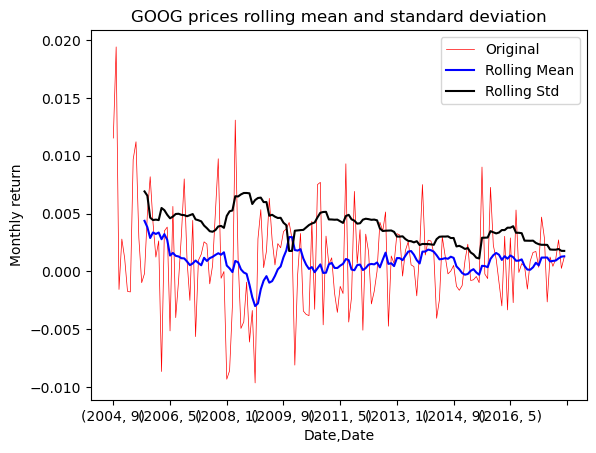

In [67]:
plot_rolling_statistics_ts(goog_monthly_return[1:],'GOOG prices rolling mean and standard deviation','Monthly return')

For the data using the `GOOG` daily prices, we can just remove the trend by subtracting the moving average from the daily prices in order to obtain the following screenshot:

* We can now observe the trend disappeared.
* Additionally, we also want to remove seasonality; for that, we can apply differentiation.
* For the differentiation, we will calculate the difference between two consecutive days; we will then use the difference as data points.

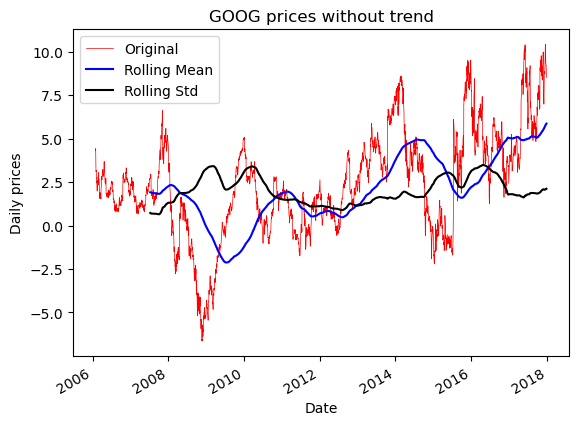

In [68]:
plot_rolling_statistics_ts(goog_data['Adj Close']-goog_data['Adj Close'].rolling(365).mean(),'GOOG prices without trend','Daily prices',365)

3. To confirm our observation, in the code, we use the popular statistical test: the augmented Dickey-Fuller test:

* This determines the presence of a unit root in time series.
* If a unit root is present, the time series is not stationary.
* The null hypothesis of this test is that the series has a unit root.
* If we reject the null hypothesis, this means that we don't find a unit root.
* If we fail to reject the null hypothesis, we can say that the time series is non- stationary:

In [69]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries[1:], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    print (dfoutput)

test_stationarity(goog_data['Adj Close'])

Results of Dickey-Fuller Test:
Test Statistic                    1.237205
p-value                           0.996233
#Lags Used                       29.000000
Number of Observations Used    3335.000000
dtype: float64


4. This test returns a p-value of 0.99. Therefore, the time series is not stationary. Let's have a look at the test:

In [70]:
test_stationarity(goog_monthly_return[1:])

Results of Dickey-Fuller Test:
Test Statistic                -1.284832e+01
p-value                        5.420167e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.580000e+02
dtype: float64


This test returns a p-value of less than 0.05. Therefore, we cannot say that the time series is not stationary. We recommend using daily returns when studying financial products. In the example of stationary, we could observe that no transformation is needed.

5. The last step of the time series analysis is to forecast the time series. We have two possible scenarios:

* A strictly stationary series without dependencies among values. We can use a regular linear regression to forecast values.
* A series with dependencies among values. We will be forced to use other statistical models. In this chapter, we chose to focus on using the **Auto-Regression Integrated Moving Averages (ARIMA)** model. This model has three parameters:
    * Autoregressive *(AR)* term *(p)*—lags of dependent variables. Example for 3, the predictors for *x(t)* is *x(t-1) + x(t-2) + x(t-3)*.
    * Moving average *(MA)* term *(q)*—lags for errors in prediction. Example for 3, the predictor for *x(t)* is *e(t-1) + e(t-2) + e(t-3)*, where *e(i)* is the difference between the moving average value and the actual value.
    * Differentiation *(d)*— This is the *d* number of occasions where we apply differentiation between values, as was explained when we studied the `GOOG` daily price. If *d=1*, we proceed with the difference between two consecutive values.

The parameter values for AR(p) and MA(q) can be respectively found by using the **autocorrelation function (ACF) and the partial autocorrelation function (PACF)**:

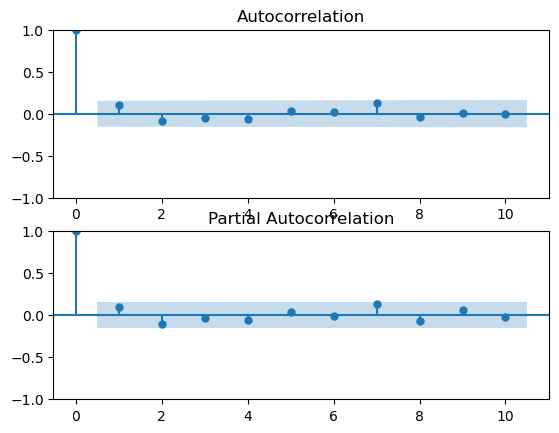

In [71]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

pyplot.figure()
pyplot.subplot(211)
plot_acf(goog_monthly_return[1:], ax=pyplot.gca(),lags=10)
pyplot.subplot(212)
plot_pacf(goog_monthly_return[1:], ax=pyplot.gca(),lags=10)
pyplot.show()

When we observe the two preceding diagrams, we can draw the confidence interval on either side of 0. We will use this confidence interval to determine the parameter values for the AR(p) and MA(q).

* **q**: The lag value is q=1 when the ACF plot crosses the upper confidence interval for the first time.
* **p**: The lag value is p=1 when the PACF chart crosses the upper confidence interval for the first time.

6. These two graphs suggest using *q=1* and *p=1*. We will apply the ARIMA model in the following code:

/Users/yusun/Developer/miniconda3/envs/lab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yusun/Developer/miniconda3/envs/lab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yusun/Developer/miniconda3/envs/lab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


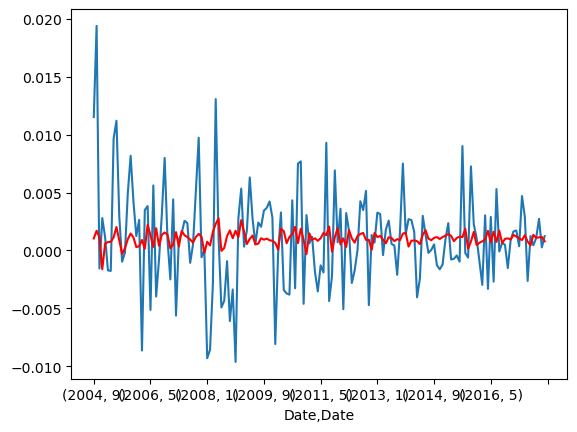

In [72]:
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(goog_monthly_return[1:], order=(2, 0, 2))
fitted_results = model.fit()
goog_monthly_return[1:].plot()
fitted_results.fittedvalues.plot(color='red')
plt.show()